**Fine tuning mdeBERTaV3 for the purpose of GED**

 

In [1]:
#INB: you might have to install some of the following packages to run this notebook:

#!sudo pip uninstall transformers -y 
#!pip install transformers[sentencepiece]
# !pip install --upgrade pip
# !pip install accelerate
# #!pip install sentencepiece
# !pip install --no-cache-dir transformers sentencepiece

In [2]:
#IMPORT PACKAGES

from transformers import AutoModel
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import gc
import itertools
from itertools import groupby
from itertools import repeat
from itertools import chain
from tqdm import tqdm

from collections import Counter

from accelerate import Accelerator

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.utils import class_weight
from sklearn.metrics import fbeta_score

# ----------
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "0"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [3]:
#SET UP MODEL CONFIG

config = {
    'model': 'microsoft/mdeberta-v3-base',  
    'dropout': 0.3,
    'max_length': 128, #512
    'batch_size': 2, #default 8 #4 #2 #1
    'epochs': 7, #7 
    'lr': 3e-04, #default: 3e-04
    'enable_scheduler': True,
    'scheduler': 'CosineAnnealingWarmRestarts',
    'gradient_accumulation_steps': 2,
    'adam_eps': 1e-6, # 1e-8 default, 1e-6 as set in the example
    'freeze_encoder': True
}
#look into hyperparameters sereach

In [4]:
#SET UP TOKENIZER

tokenizer = AutoTokenizer.from_pretrained(config['model'],use_fast=False)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
#READ THE DATA USING CSV

def load_data(language):
  train_df = pd.read_csv(f'./thesis_data/{language}_train.txt',sep='\t',header=None,names=["token","C/I"],skip_blank_lines=False)
  test_df = pd.read_csv(f'./thesis_data/{language}_test.txt',sep='\t',header=None,names=["token","C/I"],skip_blank_lines=False)
  dev_df = pd.read_csv(f'./thesis_data/{language}_dev.txt',sep='\t',header=None,names=["token","C/I"],skip_blank_lines=False)
  return train_df, test_df, dev_df

In [6]:
#DEFININE OUR TRAIN, TEST AND DEVELOPMENT SET

train_df=load_data('sv')[0]
test_df=load_data('sv')[1]
dev_df=load_data('sv')[2]

In [7]:
#VISUALISING OUR DATA

print(train_df.head(10))
print(test_df.head(10))
print(dev_df.head(10))

       token  C/I
0         Nu    c
1        ska    c
2        jag    c
3     brätta    i
4         om    c
5        det    c
6          .    c
7        NaN  NaN
8  Budskapet    c
9       från    c
      token C/I
0       Jag   c
1      vill   c
2     lämna   c
3       ett   c
4    anslag   i
5      till   c
6   Sverige   i
7  regering   c
8       för   i
9       att   c
           token C/I
0             På   c
1          grund   c
2             av   c
3          detta   c
4             är   c
5            det   c
6       rättvist   c
7            att   c
8          sänka   c
9  åldersgränsen   c


In [8]:
#VISUALISING OUR COLUMNS

print(train_df.columns.to_list())

['token', 'C/I']


In [9]:
#PROCESS THE DATAFRAME

def process_df(df,is_test=False):

  '''This function processes the data by adding EOS tokens at the end of each
  sentence/sequence of labels, to facilitate the sentence tokenization.

  It takes a dataframe as an parameter.
  The user can also optionally set is_test to True; if so, only the sentences
  will be processed and not the sequence of labels.
  
  Return: a dataframe'''

  df['token'] = df['token'].fillna(value="EOS")
  if not is_test:
    df['C/I'] =df['C/I'].fillna(value="EOS")
    return df
  return df

In [10]:
#PROCESS THE DATA

train_df=process_df(train_df)
dev_df=process_df(dev_df)
test_df=process_df(test_df)

In [11]:
#VISUALISE THE DATA

print(dev_df.head(10))
print(train_df.head(10))
print(test_df.head(10))

           token C/I
0             På   c
1          grund   c
2             av   c
3          detta   c
4             är   c
5            det   c
6       rättvist   c
7            att   c
8          sänka   c
9  åldersgränsen   c
       token  C/I
0         Nu    c
1        ska    c
2        jag    c
3     brätta    i
4         om    c
5        det    c
6          .    c
7        EOS  EOS
8  Budskapet    c
9       från    c
      token C/I
0       Jag   c
1      vill   c
2     lämna   c
3       ett   c
4    anslag   i
5      till   c
6   Sverige   i
7  regering   c
8       för   i
9       att   c


In [12]:
#GETTING THE SENTENCES AND LABELS

def get_sents_labels(df, is_test=False):

  '''This function groups the sentences and the corresponding labels.
  It takes a dataframe as an input.
  Optionally, the user can indicate if the df is the test set.
  
  This function creates a tuple with the input sentences and corresponding 
  list of labels:
  (["sentence 1","sentence 2"],[labels 1, labels 2])
  
  Or a tuple with just a list of sentences for the test set:
  (["sentence 1","sentence 2"])

  Return: a tuple
  '''

  tokens=" ".join(list(df["token"]))
  sents=tokens.split("EOS")[:-1] #getting rid of the last empty string 

  if is_test:

    return tuple([sents])
  
  else:

    all_labels=" ".join(list(df["C/I"]))
    labels=all_labels.split("EOS")[:-1]

    return sents, labels

In [13]:
#PROCESSING THE DATA

train_inputs=get_sents_labels(train_df)
dev_inputs=get_sents_labels(dev_df)
test_inputs=get_sents_labels(test_df, is_test=False)

In [14]:
#VISUALISING THE DATA

print(train_inputs)
print(dev_inputs)
print(test_inputs)

(['Nu ska jag brätta om det . ', ' Budskapet från boken är ju att föräldrarna i vissa länder måste förstå vad deras barn behöver och tvinga inte de att gör nånting som de vill inte göra . ', ' När hon ropar pappa kommer allt blir annorlunda , barn springer för att gömma sig , kamma sig och tvätta sig . ', ' Fängelset ', ' Jag vill skriva och berätta om min sambo därför att han är en person som jag älskar . ', ' Där finns många museum som är grattis så turisterna besöka dem . ', ' En vinter hade jag inte alls en vinterjacka , eftersom hittade jag inte en som jag skulle ha velat . ', ' Varför tog människorna sig till medverkan i denna olagliga verksamheter ? ', ' Jag känner många vänner där och jag har några släkter så jag hoppas att jag kan visa sig i sommaren . ', ' Det är helt olampligt att komma till en bröllop , till exempel , i en vit klänning . ', ' Jag ger boken betyget 6 av 10 för den litte svårt . ', ' Garnert . ', ' Jag är gift med Kim . ', ' Det är just därför jag inte tycker

In [19]:
#CHECKING MAX LENGTH OF THE INPUT

def max_length(inputs):
    inputs=[input.strip().split() for input in inputs[0]]
    longest_input=max(inputs, key=len)
    #print(longest_input)
    return len(longest_input)

In [20]:
#PRINTING THE MAX LENGTH OF EACH DATASET

print(f"The longest sentences of each dataset have a length of {max_length(train_inputs)} (train), {max_length(dev_inputs)} (development), {max_length(test_inputs)} (test), {max_length(test_inputs)} (self-test)")

The longest sentences of each dataset have a length of 217 (train), 84 (development), 88 (test), 88 (self-test)


In [21]:
#LABEL 2 IDX DICTIONARY
#Will be used to convert the labels to numerical values for torch.tensor

label2idx={"c":1, "i":2, "X":2, "SPLITTER":0, "EMPTY":0}
print(label2idx)

{'c': 1, 'i': 2, 'X': 2, 'SPLITTER': 0, 'EMPTY': 0}


In [22]:
#DATA PROCESSING

class GetDataset:
  
    '''This class processes the data that will be fed to the model later on.
    First, it encodes each sentence. Then, based on the encodings and subtokens,
    it re-matches the labels corresponding to this sentence.
    The labels of the subtokens is always "X".
    It then matches the labels to their corresponding numerical value
    in label2idx.

    Return: a tuple with dictionaries of tensors ({sentence},{labels})
    or just a tensor {sentence} for the test set'''

    def __init__(self, inputs, config, tokenizer=None, is_test=False, verify_rematching=False):
        self.inputs=inputs
        self.classes = ['C/I']
        self.max_len = config['max_length']
        self.tokenizer = tokenizer
        self.is_test = is_test
        self.verify_rematching=verify_rematching
        
    def __getitem__(self,idx): #gets an indiviual element from the sample

        #get element at index idx in the 0th element of the tuple
        #=the list of tokenized sentences
        sample = self.inputs[0][idx].split() 
 
        #Then, we can tokenize our sentences
        tokenized = tokenizer.encode_plus(self.inputs[0][idx], #the full sentence
                                      None, #what does that stand for?
                                      add_special_tokens=True, #encode the sequences with the special tokens relative to their model.
                                      max_length=self.max_len, #maximum length for truncation?
                                      truncation=True, #Activates truncation to a maximum length specified with the argument max_length
                                      padding='max_length' #the padding will go up until max_length 
                                     )
  

        #Converting our inputs to tensors
        inputs = {
            "input_ids": torch.tensor(tokenized['input_ids'], dtype=torch.long), #replace with encoding
            "token_type_ids": torch.tensor(tokenized['token_type_ids'], dtype=torch.long), #you should probably stack the token_type-ids too, as well as the attention mask.
            "attention_mask": torch.tensor(tokenized['attention_mask'], dtype=torch.long)
        }
        
        #if you pass the test set: just encode the sample
        if self.is_test:
          return inputs
        
        #otherwise, perform further data transformations on labels, so as to match 
        #them to the newly tokenized sentence
        else: 

          #get the labels
          labels=self.inputs[1][idx].split()
          #print("Selected sample:",sample)

          #match the sentence with its labels
          matched_tokens=list(zip(sample,labels))

          new_labels=[]

          #for each word/label pair
          for token in matched_tokens:
            #encode the word
            word_encoding=tokenizer.encode_plus(token[0])
            #check the length
            len_subtokens=len(word_encoding['input_ids'])-2

            #if the length >1, there are subtokens
            if len_subtokens>1:
              #add the corresponding label as many times as there are subtokens/add X as many times as there are subtokens
              new_labels.append(token[1])
              new_labels.extend([token[1]]*(len_subtokens-1)) #DIFFERENT: rplace X with token[1]
            
            #otherwise, just add the token
            else:
              new_labels.append(token[1])

          #ADD SPECIAL LABELS
          new_labels.append("SPLITTER")
          new_labels.insert(0,"SPLITTER")
          len_padding=len(new_labels)
          #print(len_padding, self.max_len)
          new_labels.extend(["EMPTY" for i in range(self.max_len-len_padding)])
          #print("New labels:",new_labels)
          #print(len(new_labels))
          if len(new_labels)>self.max_len:
            del new_labels[self.max_len:]

        #Mapping the labels to their numerical values in dict2idx
        numerical_labels=[label2idx[k] for k in new_labels]
         
        targets = {
            "labels": torch.tensor(numerical_labels, dtype=torch.int8),
        }

        #Checking that the re-matching was successful
        if self.verify_rematching:
          if len(tokenizer.encode_plus(self.inputs[0][idx])['input_ids']) != len_padding:
            print(f"Error: the length of the labels does not correspond to the length of the encoding.\n Length of the encoding: {len(tokenizer.encode_plus(self.inputs[0][idx])['input_ids'])-2}\n length of the new labels: {len(new_labels)}")
            print(sample, new_labels,tokenizer.encode_plus(self.inputs[0][idx]))


        return inputs, targets #inputs and labels
    
    def __len__(self):
        return len(self.inputs[0])

In [23]:
#PROCESSING OUR DATA

train_ds = GetDataset(train_inputs, config, tokenizer=tokenizer, verify_rematching=True) #bring it back to input when you train the model for real
dev_ds = GetDataset(dev_inputs, config, tokenizer=tokenizer, verify_rematching=True)
test_ds = GetDataset(test_inputs, config, tokenizer=tokenizer, verify_rematching=True, is_test=False)

In [24]:
#CHECKING THE PROCESSING

test_ds[27]

({'input_ids': tensor([     1,    432,   9211,    260,    267,  27847,   3600,   1565,    260,
           28178,    296,    714,    270,    513,    260,  42890,    260,    267,
          120581,  99043,   1288,    270,    513,    589,   8711,  61917,  10825,
             391, 106498,   1288,   1034,    273,    270,    621,   1967,  37944,
             500,    306,    287,  44573,    287,    260,    261,      2,      0,
               0,      0,      0,      0,      0,      0,      0,      0,      0,
               0,      0,      0,      0,      0,      0,      0,      0,      0,
               0,      0,      0,      0,      0,      0,      0,      0,      0,
               0,      0,      0,      0,      0,      0,      0,      0,      0,
               0,      0,      0,      0,      0,      0,      0,      0,      0,
               0,      0,      0,      0,      0,      0,      0,      0,      0,
               0,      0,      0,      0,      0,      0,      0,      0,      0,
   

In [25]:
#CHECKING THAT THE PADDING WORKED

def check_length_tensors(data):
    '''Checking that each tensor has a a maximum length of max_length'''
    for i in tqdm(range(len(data))):
        if len(data[i][0]['input_ids'])!=config['max_length']:
               print("error inputs ids",len(data[i][0]['input_ids']))
        if len(data[i][0]['attention_mask'])!=config['max_length']:
               print("error attention mask",len(data[i][0]['input_ids']))
        if len(data[i][0]['token_type_ids'])!=config['max_length']:
               print("error token type ids",len(data[i][0]['input_ids']))
        if len(data[i][1]['labels'])!=config['max_length']:
               print("error labels",len(data[i][0]['input_ids']),len(data[i][1]['labels']))

In [26]:

check_length_tensors(self_test_ds)

In [27]:
#CHECKING THE RE-MATCHING

def check_label_rematching(inputs,dataset):
    '''For each sentence of the inputs, makes the matching check from GetDataset '''
    for i in tqdm(range(len(inputs[0]))):
      dataset[i]

In [28]:
check_label_rematching(train_inputs,train_ds)
check_label_rematching(dev_inputs,dev_ds)
check_label_rematching(test_inputs,test_ds)

100%|████████████████████████████████████████████████████████████████████████████████| 913/913 [00:01<00:00, 481.70it/s]


In [29]:
#LOADING THE DATA

train_loader = torch.utils.data.DataLoader(train_ds,
                                           batch_size=config['batch_size'],
                                           shuffle=True, #reshuffle the data at every epoch
                                           num_workers=0, #number of subprocesses used for the data loading
                                           pin_memory=True #from tensor.utilis.data: If True, the data loader will copy Tensors into device/CUDA pinned memory before returning them.
                                          )
dev_loader = torch.utils.data.DataLoader(dev_ds,
                                         batch_size=config['batch_size'],
                                         shuffle=True,
                                         num_workers=0,
                                         pin_memory=True
                                        )
test_loader = torch.utils.data.DataLoader(test_ds,
                                         batch_size=config['batch_size'],
                                         shuffle=False, #True
                                         num_workers=0,
                                         pin_memory=True
                                        )

In [30]:

#CHECKING THE LOADER SHAPES
print('loader shapes:',len(train_loader), len(dev_loader),len(test_loader))

loader shapes: 3364 456 457


In [31]:
#MEAN POOLING

class MeanPooling(nn.Module): #calculates the average values for patch of feature maps
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [32]:
#MODEL

class mdeBERTaModel(nn.Module):
    def __init__(self,config,num_classes=2):
        super(mdeBERTaModel,self).__init__()
        self.model_name = config['model']
        self.freeze = config['freeze_encoder'] #whether or not the weights are frozen from encoder to decoder (here: true)
        
        self.encoder = AutoModel.from_pretrained(self.model_name) #automatically creates an instance from the model name
        if self.freeze:
            for param in self.encoder.base_model.parameters():
                param.requires_grad = False #gradients dont need to be computed here, since they are the same than in the encoder
                
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(config['dropout']) #neurons to be ignored to avoid overfitting
        self.fc1 = nn.Linear(self.encoder.config.hidden_size,256) #two linear layers, this one reduces the feature space to 64. 
        #Reduces overfitting, bottleneck, previously of size 64
        self.fc2 = nn.Linear(256,config['max_length']) #final layer
        
        
    def forward(self,inputs): #takes inputs as a parameters
        
        #WITH MEAN POOLING
        outputs = self.encoder(**inputs,return_dict=True) #input goes through encoder, put it back to True if you put the MeanPooling back
        outputs = self.pooler(outputs['last_hidden_state'], inputs['attention_mask']) #last hidden state and attention masked are passed into the pooling        
        outputs = self.fc1(outputs) 
        outputs = self.fc2(outputs) #passes through the final layers to get probabilities
        return outputs #probabilities

In [33]:
#TRAINER

class Trainer:
    def __init__(self, model, loaders, config, accelerator):
        self.model = model
        self.train_loader, self.dev_loader = loaders
        self.config = config
        self.input_keys = ['input_ids','token_type_ids','attention_mask']
        self.accelerator = accelerator #accelerators speed up the processing (more efficient with matrix calculations)
        
        self.optim = self._get_optim()
        
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optim, T_0=5,eta_min=1e-7)
        
        self.train_losses = []
        self.val_losses = []
        
    def prepare(self):
        self.model, self.optim, self.train_loader, self.dev_loader, self.scheduler = self.accelerator.prepare(
            self.model, 
            self.optim, 
            self.train_loader, 
            self.dev_loader, 
            self.scheduler
        )
        
    def _get_optim(self):
        no_decay = ['bias', 'LayerNorm.weight'] #weight decay helps improve accuracy. Here: list of params that should not be decayed
        optimizer_grouped_parameters = [
            #specifies parameters to be decay
            {'params': [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.0001}, 
            #specifies parameters to not be decayed
            {'params': [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
        optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=self.config['lr'], eps=self.config['adam_eps']) #optimizer is AdamW
        return optimizer

        
    def loss_fn(self, outputs, targets): 

      #LOSS FUNCTION: CROSS-ENTROPY LOSS WITH ADDED WEIGHT
        colwise_mse = torch.mean(torch.square(targets - outputs), dim=0) 
        
        modified_mse = torch.where((targets == 2) & ((torch.round(outputs) == 0) | (torch.round(outputs) == 1)), colwise_mse * 50, colwise_mse)

        loss = torch.mean(torch.sqrt(modified_mse))
        return loss
    
    
    def train_one_epoch(self,epoch):
        
        running_loss = 0.
        progress = tqdm(self.train_loader, total=len(self.train_loader))
        
        for idx,(inputs,targets) in enumerate(progress):
            with self.accelerator.accumulate(self.model):
            
                outputs = self.model(inputs)

                loss = self.loss_fn(outputs, targets['labels'])
                running_loss += loss.item() #running loss: average of loss across all batches - here, it is update before calculating the average

                self.accelerator.backward(loss)
                
                self.optim.step()
                
                if self.config['enable_scheduler']:
                    self.scheduler.step(epoch - 1 + idx / len(self.train_loader))
                    
                self.optim.zero_grad() #sets the gradients to 0

                del inputs, targets, outputs, loss
            
            
        train_loss = running_loss/len(self.train_loader) #average loss is calculated
        self.train_losses.append(train_loss)
        
    @torch.no_grad() #python decorator: modifies behaviour of a function/class
    #used to avoid re-calculating gradients

    def valid_one_epoch(self,epoch): #checking how the model behaves with unseen data
        
        running_loss = 0.
        progress = tqdm(self.dev_loader, total=len(self.dev_loader))
        
        for (inputs, targets) in progress:
            
            outputs = self.model(inputs)
            
            loss = self.loss_fn(outputs, targets['labels'])
            running_loss += loss.item()
            
            #no backwardfn used, no gradients = no weights are updated

            del inputs, targets, outputs, loss
            
        
        val_loss = running_loss/len(self.dev_loader)
        self.val_losses.append(val_loss)
        
    
    def test(self, test_loader):
        
        preds = []
        for (inputs) in test_loader:
            
            outputs = self.model(inputs)
            preds.append(outputs.detach().cpu()) #detached from the computational graph so that it can be manipulated on the cpu
            
        preds = torch.concat(preds)
        return preds
    
    def fit(self):
        
        self.prepare() #sets the model and a wide range of params
        
        fit_progress = tqdm(
            range(1, self.config['epochs']+1),
            leave = True,
            desc="Training..."
        )
        
        for epoch in fit_progress:
            
            self.model.train() #train function of the model
            fit_progress.set_description(f"EPOCH {epoch} / {self.config['epochs']} | training...")
            self.train_one_epoch(epoch)
            self.clear()
            
            self.model.eval()
            fit_progress.set_description(f"EPOCH {epoch} / {self.config['epochs']} | validating...")
            self.valid_one_epoch(epoch)
            self.clear()

            print(f"{'➖️'*10} EPOCH {epoch} / {self.config['epochs']} {'➖️'*10}")
            print(f"train loss: {self.train_losses[-1]}")
            print(f"valid loss: {self.val_losses[-1]}\n\n")
            
    
    def clear(self):
        gc.collect() #frees up memory space
        torch.cuda.empty_cache() #clears up memory cache

In [34]:
#DEFINE ACCELERATOR

accelerator = Accelerator(gradient_accumulation_steps=config['gradient_accumulation_steps'])

In [35]:
#TRAIN WITH ACCELERATE

model = mdeBERTaModel(config).to(device=accelerator.device)
trainer = Trainer(model, (train_loader, dev_loader), config, accelerator)

Some weights of the model checkpoint at microsoft/mdeberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'deberta.embeddings.word_embeddings._weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSeque

In [36]:
#TRAIN

trainer.fit()

EPOCH 1 / 7 | training...:   0%|                                                                  | 0/7 [00:00<?, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 3364/3364 [10:27<00:00,  5.36it/s]
EPOCH 1 / 7 | validating...:   0%|                                                                | 0/7 [10:27<?, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 456/456 [00:58<00:00,  7.79it/s]
EPOCH 2 / 7 | training...:  14%|███████▊                                               | 1/7 [11:26<1:08:39, 686.64s/it]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 1 / 7 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.3389877921189586
valid loss: 0.3162806298616424





100%|███████████████████████████████████████████████████████████████████████████████| 3364/3364 [10:08<00:00,  5.53it/s]
EPOCH 2 / 7 | validating...:  14%|███████▌                                             | 1/7 [21:35<1:08:39, 686.64s/it]
100%|█████████████████████████████████████████████████████████████████████████████████| 456/456 [00:43<00:00, 10.59it/s]
EPOCH 3 / 7 | training...:  29%|████████████████▎                                        | 2/7 [22:18<55:31, 666.34s/it]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 2 / 7 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.3069605143545871
valid loss: 0.2992279344123968





100%|███████████████████████████████████████████████████████████████████████████████| 3364/3364 [03:33<00:00, 15.72it/s]
EPOCH 3 / 7 | validating...:  29%|███████████████▋                                       | 2/7 [25:52<55:31, 666.34s/it]
100%|█████████████████████████████████████████████████████████████████████████████████| 456/456 [00:22<00:00, 20.20it/s]
EPOCH 4 / 7 | training...:  43%|████████████████████████▍                                | 3/7 [26:15<31:20, 470.23s/it]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 3 / 7 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.2973549334126371
valid loss: 0.30788512462586687





100%|███████████████████████████████████████████████████████████████████████████████| 3364/3364 [03:34<00:00, 15.65it/s]
EPOCH 4 / 7 | validating...:  43%|███████████████████████▌                               | 3/7 [29:50<31:20, 470.23s/it]
100%|█████████████████████████████████████████████████████████████████████████████████| 456/456 [00:22<00:00, 20.20it/s]
EPOCH 5 / 7 | training...:  57%|████████████████████████████████▌                        | 4/7 [30:13<18:55, 378.47s/it]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 4 / 7 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.29138362824066355
valid loss: 0.2956872441756882





100%|███████████████████████████████████████████████████████████████████████████████| 3364/3364 [07:29<00:00,  7.48it/s]
EPOCH 5 / 7 | validating...:  57%|███████████████████████████████▍                       | 4/7 [37:43<18:55, 378.47s/it]
100%|█████████████████████████████████████████████████████████████████████████████████| 456/456 [00:22<00:00, 20.21it/s]
EPOCH 6 / 7 | training...:  71%|████████████████████████████████████████▋                | 5/7 [38:06<13:44, 412.43s/it]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 5 / 7 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.2886304817661891
valid loss: 0.2930177007393356





100%|███████████████████████████████████████████████████████████████████████████████| 3364/3364 [03:34<00:00, 15.69it/s]
EPOCH 6 / 7 | validating...:  71%|███████████████████████████████████████▎               | 5/7 [41:40<13:44, 412.43s/it]
100%|█████████████████████████████████████████████████████████████████████████████████| 456/456 [00:22<00:00, 20.20it/s]
EPOCH 7 / 7 | training...:  86%|████████████████████████████████████████████████▊        | 6/7 [42:03<05:52, 352.88s/it]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 6 / 7 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.29986670049955
valid loss: 0.31742759483555955





100%|███████████████████████████████████████████████████████████████████████████████| 3364/3364 [03:34<00:00, 15.69it/s]
EPOCH 7 / 7 | validating...:  86%|███████████████████████████████████████████████▏       | 6/7 [45:37<05:52, 352.88s/it]
100%|█████████████████████████████████████████████████████████████████████████████████| 456/456 [00:22<00:00, 20.22it/s]
EPOCH 7 / 7 | validating...: 100%|███████████████████████████████████████████████████████| 7/7 [46:00<00:00, 394.38s/it]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 7 / 7 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.2947821388814009
valid loss: 0.29280622140095947




RESULT LOSSES

In [37]:
#GETTING THE LOSSES

losses_df = pd.DataFrame({'epoch':list(range(1,config['epochs'] + 1)),
                          'train_loss':trainer.train_losses, 
                          'val_loss': trainer.val_losses
                         })

In [38]:
#PRINTING THE LOSSES

losses_df

epoch  train_loss  val_loss
0      1    0.338988  0.316281
1      2    0.306961  0.299228
2      3    0.297355  0.307885
3      4    0.291384  0.295687
4      5    0.288630  0.293018
5      6    0.299867  0.317428
6      7    0.294782  0.292806

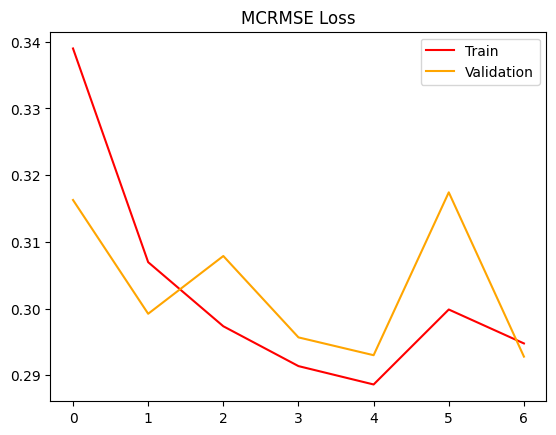

In [39]:
#PLOTTING THE LOSSES

plt.plot(trainer.train_losses, color='red')
plt.plot(trainer.val_losses, color='orange')
plt.title('MCRMSE Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

TESTING

In [40]:
#GET PREDICTIONS

def predict(data_loader, model):
    model.to(device=accelerator.device)
    model.eval()
    y_pred = []
    y_true=[]

    for batch in tqdm(data_loader):
        labels=batch[1]['labels'].tolist()
        y_true.append(labels)
    
    
        with torch.no_grad():
            inputs={key:value.to(device=accelerator.device) for key, value in batch[0].items()}
            outputs = model(inputs)

        rounded_outputs = np.trunc(outputs.detach().cpu().numpy()) #truncate instead of rounding
        y_pred.extend(rounded_outputs)
    
    y_pred = np.vstack(y_pred).tolist()
    y_true = [inner_list for sublist in y_true for inner_list in sublist]

    return y_true,y_pred

In [41]:
#COLLECTING PREDICTIONS

y_true_pred=predict(test_loader, model)


100%|█████████████████████████████████████████████████████████████████████████████████| 457/457 [00:22<00:00, 20.63it/s]


In [42]:
#GETTING THE TRUE AND PREDICTED VALUES

unprocessed_y_true=y_true_pred[0]
unprocessed_y_pred=y_true_pred[1]


In [43]:
#VISUALISING THE DATA
print(unprocessed_y_true[27])

[0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [44]:
#VISUALISE PREDICTIONS AND TRUE VALUES

print("Truth",unprocessed_y_true[0])
print("Prediction",unprocessed_y_pred[0])
print("Truth",unprocessed_y_true[1])
print("Prediction",unprocessed_y_pred[1])

Truth [0, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Prediction [-0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0

In [45]:
#CHECKING THE SIMILARITY BETWEEN THE PREDICTIONS AND THE TRUTH

def output_similarity(y_pred):
    counter={}
    for i in tqdm(range(len(y_pred[0]))):
        element_i=[]
        for prediction in y_pred:
            element_i.append(prediction[i])
        counter[i]=dict(Counter(element_i))
    return counter

In [46]:
prediction_counter=output_similarity(unprocessed_y_pred)
truth_counter=output_similarity(unprocessed_y_true)


100%|███████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 6326.77it/s]


In [47]:
#CREATING A FUNCTION FOR DATA VISUALISATION

def plot_counted_values(data):
    positions = []
    zeros = []
    ones = []
    twos = []
    threes = []
    fours = []

    for position, values in data.items():
        positions.append(position)
        zeros.append(values.get(0.0, 0))
        ones.append(values.get(1.0, 0))
        twos.append(values.get(2.0, 0))
        threes.append(values.get(3.0, 0))
        fours.append(values.get(4.0, 0))

    plt.plot(positions, zeros, label='0')
    plt.plot(positions, ones, label='1')
    plt.plot(positions, twos, label='2')
    plt.plot(positions, threes, label='3')
    plt.plot(positions, fours, label='4')

    plt.xlabel('Position')
    plt.ylabel('Count')
    plt.title('Counts of 0s, 1s, 2s, 3s, 4s at Each Position')
    plt.legend()
    plt.grid(True)
    plt.show()

Predictions:


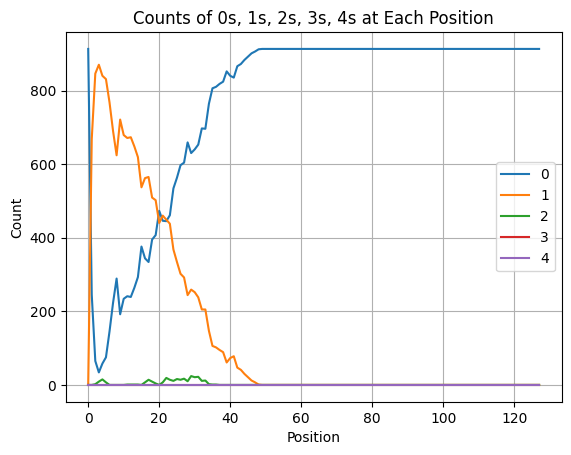

Truth:


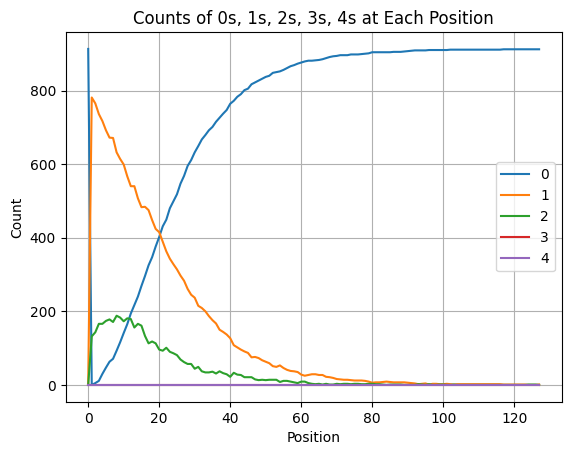

In [48]:
#PLOTTING THE PREDICTIONS AND TRUE VALUES

print("Predictions:")
plot_counted_values(prediction_counter)
print("Truth:")
plot_counted_values(truth_counter)

EVALUATE THE MODEL WITHOUT FURTHER PROCESSING

In [49]:
#EXACT MATCH ACCURACY PER LABEL

def exact_match_accuracy(y_true_preds):
    acc = 0
    total=0
    for x,y in zip(y_true_preds[0], y_true_preds[1]):
        for a,b in zip(x,y):
            if a == b:
                acc += 1
            total+=1
    return acc/total

In [50]:
print("Percentage of correct tokens: ")
exact_match_accuracy(y_true_pred)

Percentage of correct tokens: 


0.9182040662650602

PROCESS THE PREDICTIONS

STEPS

1: remove all the empty labels + testing that they were correctly removed

2: check how good the model is at predicting the correct length

3: fit the length of the predictions to the length of the gold standards + testing that the lengths fit

4: compute exact sentence matching

5: flatten all sentences to compute acc/f1/recall/precision

In [51]:
print(label2idx)

{'c': 1, 'i': 2, 'X': 2, 'SPLITTER': 0, 'EMPTY': 0}


In [52]:
#1 REMOVE ALL EMPTY LABELS

def filter_data(list_of_labels):
    filtered_predictions=[[x for x in sublist if x not in [0]] for sublist in list_of_labels]    
    return filtered_predictions

In [53]:
filtered_y_true=filter_data(unprocessed_y_true)
filtered_y_pred=filter_data(unprocessed_y_pred)

In [54]:
#TEST FILTERING

def display_filtered_data(unprocessed_data,filtered_data,n):
    for pair in list(zip(unprocessed_data,filtered_data))[:n]:
        print("This should contain empty tokens:\n",pair[0],"\nThis should not:\n",pair[1])

In [55]:
display_filtered_data(unprocessed_y_true,filtered_y_true,2)

This should contain empty tokens:
 [0, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 
This should not:
 [1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1]
This should contain empty tokens:
 [0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 
This should not:
 [1, 1, 

In [56]:
#2 CHECKING HOW GOOD THE MODEL IS AT PREDICTING THE CORRECT LENGTH

def length_predictions(filtered_y_true,filtered_y_pred):
    count=0
    count_longer_preds=0
    count_shorter_preds=0
    for data_point in zip(filtered_y_true,filtered_y_pred):
        if len(data_point[0])!=len(data_point[1]):
            count+=1
            #print(len(data_point[0]),len(data_point[1]))
        if len(data_point[0])<len(data_point[1]):
            count_longer_preds+=1
        if len(data_point[0])>len(data_point[1]):
            count_shorter_preds+=1
    print(f"Number of sentences of wrong length: {count} over {len(filtered_y_true)} \nNumber of predictions that are too long: {count_longer_preds}\nNumber of predictions that are too short: {count_shorter_preds}\nHence: {round(count/len(filtered_y_true)*100)}% are of wrong length")

In [57]:
length_predictions(filtered_y_true,filtered_y_pred)

Number of sentences of wrong length: 835 over 913 
Number of predictions that are too long: 183
Number of predictions that are too short: 652
Hence: 91% are of wrong length


In [58]:
#3 FIT THE LENGTHS OF THE PREDICTIONS

def fit_predictions(y_pred,y_true):
    truncated_predictions=[]
    for pred,truth in zip(y_pred,y_true):
        if len(pred)>len(truth):
            #print("Previous prediction: ",pred)
            del pred[len(truth):]
            #print("New truncated prediction: ",pred)
            truncated_predictions.append(pred)
        elif len(pred)<len(truth):
            #print("Previous prediction: ",pred)
            pred.extend(label2idx["SPLITTER"] for i in range(len(truth)-len(pred)))
            #print("New extended prediction: ",pred)
            truncated_predictions.append(pred)
        else:
            truncated_predictions.append(pred)
    return truncated_predictions

In [59]:
fitted_y_pred=fit_predictions(filtered_y_pred,filtered_y_true)

In [60]:
#CHECKING THE MATCHING OF THE LENGTHS

def check_matching_length(fitted_y_pred,filtered_y_true):
    for pred,truth in zip(fitted_y_pred,filtered_y_true):
        if len(pred)!=len(truth):
                print(f"Problem: the length do not match.{len(pred)}, {len(truth)}")

In [61]:
check_matching_length(fitted_y_pred,filtered_y_true)

In [62]:
#4 CHECK HOW MANY SENTENCES WERE COMPLETELY CORRECT

def exact_sentence_matching(fitted_y_pred,filtered_y_true):
    correctly_predicted_sentences=0
    total=0
    for pair in list(zip(fitted_y_pred,filtered_y_true)):
        total+=1
        if pair[0]==pair[1]:
            correctly_predicted_sentences+=1
    return correctly_predicted_sentences/total

In [63]:
print("Number of correctly predicted sentences:\n")
exact_sentence_matching(fitted_y_pred,filtered_y_true)

Number of correctly predicted sentences:



0.03176341730558598

In [64]:
#5 FLATTEN ALL THE LISTS

def flatten_list(y):
    flat_list = [item for sublist in y for item in sublist]
    return flat_list

In [65]:
y_true=flatten_list(filtered_y_true)
y_pred=flatten_list(fitted_y_pred)

In [66]:
print("Number of 0,1,2 in gold standards: ",Counter(y_true))
print("Number of 0,1,2 in predictions: ",Counter(y_pred))

Number of 0,1,2 in gold standards:  Counter({1: 18311, 2: 4556})
Number of 0,1,2 in predictions:  Counter({1.0: 17733, 0: 4861, 2.0: 273})


EVALUATION METRICS

precision, recall, f1, accuracy, for the whole set

Then, creating a confusion matrix

In [67]:
precision=precision_score(y_true, y_pred, average='weighted')
recall=recall_score(y_true, y_pred, average='weighted')
f1=f1_score(y_true, y_pred, average='weighted')
accuracy=accuracy_score(y_true,y_pred)
fbeta=fbeta_score(y_true, y_pred, average='weighted', beta=0.5)

/usr/local/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
print("Weighted metrics\n")
print("Precision:",precision)
print("Recall:",recall)
print("F1:",f1)
print("Accuracy:",accuracy)
print("F0.5:",fbeta)

Weighted metrics

Precision: 0.6828402503013651
Recall: 0.6095683736388683
F1: 0.6223140407412981
Accuracy: 0.6095683736388683
F0.5: 0.6356185938812726


The high precision/recall/F1/accuracy is not due to the fact that the model learns things (or at least, not completely). Rather, they can be explained by the fact that the model outputs gets truncated. So, all the 1s that the model wrongly predicts at the end of each sentence gets truncated. Hence, we are left with mostly 1s (which are almost always correct) and very few 2s. To get a better idea, it is necessary to evaluate the model per category.

In [69]:
macro_precision=precision_score(y_true, y_pred, average='macro')
macro_recall=recall_score(y_true, y_pred, average='macro')
macro_f1=f1_score(y_true, y_pred, average='macro')
macro_fbeta=fbeta_score(y_true, y_pred, average='macro', beta=0.5)

/usr/local/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
print("Macro metrics\n")
print("Precision:",macro_precision)
print("Recall:",macro_recall)
print("F1:",macro_f1)
print("F0.5:",macro_fbeta)

Macro metrics

Precision: 0.3557881055766354
Recall: 0.25803232054398073
F1: 0.2671401168281342
F0.5: 0.28187950365691017


In [71]:
micro_precision=precision_score(y_true, y_pred, average='micro')
micro_recall=recall_score(y_true, y_pred, average='micro')
micro_f1=f1_score(y_true, y_pred, average='micro')
micro_fbeta=fbeta_score(y_true, y_pred, average='micro', beta=0.5)

In [72]:
print("Micro metrics\n")
print("Precision:",micro_precision)
print("Recall:",micro_recall)
print("F1:",micro_f1)
print("F0.5:",micro_fbeta)

Micro metrics

Precision: 0.6095683736388683
Recall: 0.6095683736388683
F1: 0.6095683736388683
F0.5: 0.6095683736388683


ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (4).

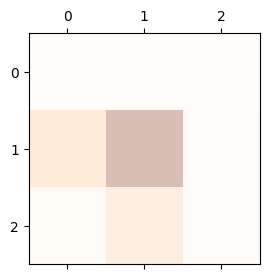

In [73]:
#MAKING A CONFUSION MATRIX
#NB: ADAPT THE TICKS TO THE RESULTS OF THE MODEL

conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)

plt.xticks(np.arange(conf_matrix.shape[1]), [ 0, 1, 2])
plt.yticks(np.arange(conf_matrix.shape[0]), [ 0, 1, 2])

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='large')
 
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.show()

CREATING A FILE FOR EVALUATION

In [ ]:
print(label2idx)

In [ ]:
#REPLACING THE LABELS BY THEIR ALPHABETICAL VALUE

c_i_dicitonary={3:"c",1:"i",2:"X",0:"X",-1:"X"}
list_labels=[[c_i_dicitonary[k] for k in sublist] for sublist in filtered_y_pred]

In [ ]:
#CHECKING IF SENTENCES GOT TRUNCATED

def match_truncated_sentences(test_inputs):
    test_sentences=[input.strip().split() for input in test_inputs[0]]

    zipped_labels=zip(test_sentences,list_labels)
    zipped_labels=list(zipped_labels)
    zipped_labels=enumerate(zipped_labels)

    for index,sentence in zipped_labels:
        if len(sentence[0])!=len(sentence[1]):
            print("Error for the sentence:",index)
            sentence[1].extend(['X']*(len(sentence[0])-len(sentence[1])))
            print(len(sentence[0]),len(sentence[1]))

In [ ]:
match_truncated_sentences(test_inputs)

In [ ]:
#ADDING LINE JUMPS AND FLATTENING THE LISTS

labels = [''.join(lst) + " " for lst in list_labels]
labels=[[x for x in string] for string in labels]
labels=flatten_list(labels)

In [ ]:
#MAKE SURE TO HAVE THE UNLABELLED TEST FILE IN THE CORRECT DIRECTORY
#CHANGE DIRECTORY NAME IF NECESSARY

def write_predictions(language):
    with open(f'./thesis_data/{language}_test_unlabelled.txt') as f:
        L = f.readlines()
        t = map(lambda s: s.strip(), L)
#         lines = (line.rstrip() for line in f) 
#         lines = (line for line in lines if line)
        t=list(t)
        token_label=[token+'\t'+label+"\n" for token,label in zip(t,labels)]
    with open(f'./thesis_data/{language}_test_unlabelled.txt','w') as f:
        for element in token_label:
            f.write(element)

In [ ]:
#write_predictions("sv")